In [2]:
#get tumor's position dataframe
import pandas as pd
import numpy as np
import os
import json
import glob
# import SimpleITK as sitk
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [6]:
import sys
sys.path.append('/workspaces/project/MegaGen')
from utils.data_utils import get_loader
from types import SimpleNamespace
args = SimpleNamespace()
args.data_dir = '/workspaces/data/brain_meningioma/slice'
args.json_list = "/workspaces/data/MegaGen/inputs/dataset_split_brats2.json"
args.fold = 0
args.spatial_dims = 2
args.roi_x = 160
args.roi_y = 192
args.test_mode = False
args.out_base = 'unet1-bras2'
args.distributed = False
args.batch_size = 8
args.workers = 8
args.nbatch_val = 1
args.shuffle=False

In [7]:
loader = get_loader(args)

In [ ]:
df_train = pd.DataFrame(loader[0].dataset.data)
df_valid = pd.DataFrame(loader[1].dataset.data)

In [27]:
df_train['id'] = df_train['label'].apply(lambda x: os.path.basename(x).split('-')[3])
df_valid['id'] = df_valid['label'].apply(lambda x: os.path.basename(x).split('-')[3])

In [9]:
def volume(names):
    total = 0
    for file in names:    
        total += np.sum(np.load(file) > 0.5)
    return total

In [ ]:

df_volume= df_train.groupby('id').aggregate(volume = ('label', volume))
df_volume = pd.concat([df_volume, df_valid.groupby('id').aggregate(volume = ('label', volume))], axis=0)

In [29]:
df_volume.count()

volume    445
dtype: int64

In [1]:
df_volume

NameError: name 'df_volume' is not defined

[ 3080. 13858.]


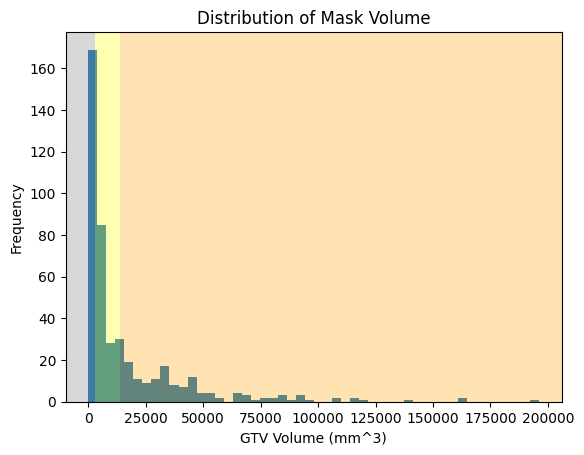

In [30]:

axes = plt.hist(df_volume['volume'], bins=50)
ymin, ymax = plt.ylim()
xmin, xmax = plt.xlim()
adiv = np.quantile(df_volume['volume'], [1/3,2/3])
print(adiv)

rect1 = patches.Rectangle((xmin, ymin), adiv[0]-xmin, ymax-ymin, linewidth=1, edgecolor='none', facecolor='grey', alpha=0.3)
rect2 = patches.Rectangle((adiv[0], ymin), adiv[1]-adiv[0], ymax-ymin, linewidth=1, edgecolor='none', facecolor='yellow', alpha=0.3)
rect3 = patches.Rectangle((adiv[1], ymin), xmax-adiv[1], ymax-ymin, linewidth=1, edgecolor='none', facecolor='orange', alpha=0.3)
# axes[0][0].add_patch(arrow1)
# fig, ax = plt.subplots()
plt.gca().add_patch(rect1)
plt.gca().add_patch(rect2)
plt.gca().add_patch(rect3)

plt.xlabel('GTV Volume (mm^3)')
plt.ylabel('Frequency')
plt.title('Distribution of Mask Volume')
plt.show()

In [ ]:
mask_sizes = [np.sum(np.load(d['label']) > 0.5) for d in loader[0].dataset.data]
mask_sizes.extend([np.sum(np.load(d['label']) > 0.5) for d in loader[1].dataset.data])
mask_sizes = np.array(mask_sizes)


In [ ]:
args.json_list = "/workspaces/data/MegaGen/inputs/dataset_split_TV_brats2.json"
loaderTV = get_loader(args)
df_test = pd.DataFrame(loaderTV[1].dataset.data)
df_test['id'] = df_test['label'].apply(lambda x: os.path.basename(x).split('-')[3])

dfT_volume= df_test.groupby('id').aggregate(volume = ('label', volume))

In [15]:
dfT_volume.sort_values('volume').to_csv('/workspaces/data/MegaGen/logs/SCORE/CSVS/id_test_volume.csv')

In [7]:
tumord.describe()
tumord.head()

,PatientID,SliceIdx,Y,X,Region,MaskPath,IoU,PredY,PredX
0,BraTS-MEN-RT-0002-1,123,85.676471,34.147059,Temporal_L,/Users/iujeong/0.local/4.slice/s_train/npy/Bra...,0.023555,55.072072,67.254505
1,BraTS-MEN-RT-0002-1,124,85.944444,34.481481,Temporal_L,/Users/iujeong/0.local/4.slice/s_train/npy/Bra...,0.039832,56.868778,66.821267
2,BraTS-MEN-RT-0002-1,125,85.944444,34.481481,Temporal_L,/Users/iujeong/0.local/4.slice/s_train/npy/Bra...,0.044750,62.226040,85.674503
3,BraTS-MEN-RT-0002-1,126,86.608247,35.041237,Temporal_L,/Users/iujeong/0.local/4.slice/s_train/npy/Bra...,0.063647,67.926166,90.937824
4,BraTS-MEN-RT-0002-1,127,86.503226,35.290323,Temporal_L,/Users/iujeong/0.local/4.slice/s_train/npy/Bra...,0.010453,67.327273,100.422378
